# Measuring and Integrating Representations of Data

In the last notebook, we saw how we can use a variety of methods (from simple statistics to deep learning) to create representations (aka vectorisations, tensorisations, embeddings) which can be used for many downstream deep learning and machine learning tasks. Another elegant and simple way to explore these vectors is through distance and similarity measurements, which allow us to perform basic information retreival tasks, and navigate unsupervised dimension reductions generated from PCA and UMAP. 

In this notebook we will focus on methods and techniques for meausring and aligning representations. 

## Measuring Between Data Representations

In this section we will introduce various distance and similarity measures and information theoretic metrics for various representations of data and probability distributions. We'll start with some very simple metrics to measure between sequences and words (as sequences of letters).

The **Hamming distance** between 1-D arrays $u$ and $v$, is simply the proportion of disagreeing components between $u$ and $v$. 

In [1]:
from scipy.spatial import distance

In [2]:
distance.hamming([1, 0, 0], [0, 1, 0])

0.6666666666666666

In [3]:
distance.hamming([1, 1, 0], [0, 1, 0])

0.3333333333333333

In [4]:
distance.hamming([0, 1, 0], [0, 1, 0])

0.0

#### Words as sequences of letters

We can use similar distance metrics for sequences of words. The python package [fuzzywuzzy](https://pypi.org/project/fuzzywuzzy/) is specifically built for word and string similarities.

In [5]:
!pip install fuzzywuzzy

In [6]:
from fuzzywuzzy import fuzz

C:\Users\parth\AppData\Local\Programs\Python\Python39\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [7]:
fuzz.ratio("this is a test", "this is a test!")

97

In [8]:
fuzz.partial_ratio("this is a test", "this is a test!")

100


The next sections of the notebook will contain distance metrics built into another package we have used extensively, Gensim, and uses material previously written by the author ([link 1](https://github.com/bhargavvader/personal/blob/master/notebooks/gensim/distance_metrics.ipynb), [link 2](https://radimrehurek.com/gensim_3.8.3/auto_examples/tutorials/run_distance_metrics.html)). 

We use topic models as our tool of measuring between probability distributions because they are ammenable to easy analysis (we know which documents have which topics and which topics have which words easily by visual observation!). 

In [5]:
from gensim.corpora import Dictionary
from gensim.models import ldamodel
import numpy as np

In [10]:
texts = [
    ['bank','river','shore','water'],
    ['river','water','flow','fast','tree'],
    ['bank','water','fall','flow'],
    ['bank','bank','water','rain','river'],
    ['river','water','mud','tree'],
    ['money','transaction','bank','finance'],
    ['bank','borrow','money'],
    ['bank','finance'],
    ['finance','money','sell','bank'],
    ['borrow','sell'],
    ['bank','loan','sell'],
]

In [11]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [12]:
# setting random seed to get the same results each time. 
# you are welcome to change the seed but some of the  explanations on the values returned by the differences mighht not make the most sense.
np.random.seed(3) 

In [13]:
model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=2, minimum_probability=1e-8)
model.show_topics()

[(0,
  '0.199*"bank" + 0.143*"water" + 0.118*"river" + 0.065*"tree" + 0.064*"flow" + 0.051*"borrow" + 0.046*"money" + 0.042*"rain" + 0.041*"fall" + 0.041*"shore"'),
 (1,
  '0.146*"bank" + 0.129*"finance" + 0.128*"sell" + 0.113*"money" + 0.064*"transaction" + 0.058*"borrow" + 0.055*"loan" + 0.049*"water" + 0.043*"river" + 0.036*"flow"')]

Let’s call the 1st topic the water topic and the second topic the finance topic.

Let’s take a few sample documents and get them ready to test our distance functions. The first several distance functions characterize the difference between probability distributions, but the methods can accept many formats for input, and many representations can be *interpreted* as probability distributions. Topic models are explicitly built as probability distributions, but other neural network-constructed spaces can be normalized to behave like such distributions.  


In [14]:
doc_water = ['river', 'water', 'shore']
doc_finance = ['finance', 'money', 'sell']
doc_bank = ['finance', 'bank', 'tree', 'water']

# now let's make these into a bag of words format
bow_water = model.id2word.doc2bow(doc_water)
bow_finance = model.id2word.doc2bow(doc_finance)
bow_bank = model.id2word.doc2bow(doc_bank)

# we can now get the LDA topic distributions for these
lda_bow_water = model[bow_water]
lda_bow_finance = model[bow_finance]
lda_bow_bank = model[bow_bank]

### Hellinger Distance $d_H(P,Q)$ and Battacharyya coefficient $D_B(P,Q)$
We’re now ready to apply our distance metrics. These metrics return a value between 0 and 1, where values closer to 0 indicate a smaller ‘distance’ and therefore a larger similarity.

Let’s start with the straightfoward and popular Hellinger distance, $d_H(P,Q)$.$d_H(P,Q)$, the Kullback-Leibler Divergence $D_{KL}(P\|Q)$, the Jensen-Shannon Divergence $D_{JS}(P\|Q)$, and the $x^2$ Divergence. All are members of the broader [$f$-divergence](href=https://en.wikipedia.org/wiki/F-divergence) family, a function of $D_f (P\|Q)$ that calculates the difference between two probability distributions P and Q, where we treat two comparable representations as probability distributions. In the $f$-divergence family, $D_f(P\|Q)=\int_{\Omega}f(\frac{dP}{dQ})dQ$.

The Hellinger Distance $d_H(P,Q)$ is the probabilistic analog of Euclidean (straight-line) distance between two representations, interpreted as probability distributions ($P$ and $Q$): $d_H(P,Q)=\frac{1}{\sqrt{2}}\cdot \|\sqrt{P}-\sqrt{Q}\|_2$ for the discrete (and special) case. As a type of $f$-divergence, this case $f(t)=\frac{1}{\sqrt(2)}(\sqrt(t)-1)$. The Hellinger distance can be derived from the Battacharyya coefficient: if $D_B(P,Q)= \int \sqrt{p(x)q(x)}\text{dx}$, then the Hellinger distance $d_H(P,Q)=\sqrt{1-D_B(P,Q)}$. 

The Hellinger distance metric gives an output in the range [0,1] for two probability distributions, with values closer to 0 meaning they are more similar.

In [15]:
from gensim.matutils import hellinger

In [16]:
print(hellinger(lda_bow_water, lda_bow_finance))
print(hellinger(lda_bow_finance, lda_bow_bank))

0.5599429409570128
0.43456375200702657


This makes sense. In the first example, Document 1 and Document 2 are barely similar, so we get a value of roughly 0.5.

In the second case, the documents are semantically more similar. Trained with the model, they give a smaller distance value.

### Kullback–Leibler Divergence $D_{KL}(P\|Q)$

Another approach to measuring the divergence between two representations, interpreted as probability distributions, is through the Kullback-Leibler (KL) divergence. The KL $f(t)$ is $t\text{log}t$. Derived from information theory, $D_{KL}$ is a measure of the surprise one experiences when observing distribution $P$ from the perspective of another distribution $Q$. In information theoretic jargon, it computes the relative entropy between two distributions–the average difference of the number of bits required for encoding samples of $P$ using a code optimized for $Q$ rather than one optimized for $P$. This is why $KL(P\|Q)\ne KL(Q\|P)$; seeing a man dressed in a gorilla suit may be less surprising than seeing a gorilla dressed in a man suit. 

Specifically, given two discrete probability distributions $P$ and $Q$, the Kullback-Leibler divergence from $Q$ to $P$ is defined as: $D_{KL}(P\|Q) = \sum_i P(i) \log\frac{P(i)}{Q(i)}$. For example, the [scipy.stats.entropy()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) function can do it for you, taking in two arrays of probabilities and computing the KL divergence. Also note that the KL divernce is the sum of elementwise divergences. Scipy provides [scipy.special.kl_div()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html#scipy-special-kl-div) which calculates elementwise divergences for you.

In [17]:
from gensim.matutils import kullback_leibler

print(kullback_leibler(lda_bow_water, lda_bow_bank))
print(kullback_leibler(lda_bow_finance, lda_bow_bank))

0.0656577
0.7192513


Recall that $D_{KL}$ is not symmetrical:

In [18]:
print(kullback_leibler(lda_bow_bank, lda_bow_finance))

0.8571865


In our previous examples we saw that there were lower distance values between bank and water than for bank and finance, even if it wasn’t by a huge margin. What does this mean?

The bank document is a combination of both water and finance related terms - but as bank in this context is likely to belong to the water topic, the distance values are more between the finance and bank bows. 

In [19]:
# just to confirm our suspicion that the bank bow is more to do with finance:
model.get_document_topics(bow_bank)

[(0, 0.7104197), (1, 0.28958026)]

It’s evident that while it isn’t very skewed, it tends more towards the water topic.

For an informal review of the mathematical differences between Hellinger and KL, consider this Stackoverflow [question/response](https://stats.stackexchange.com/questions/130432/differences-between-bhattacharyya-distance-and-kl-divergence).

 

### Jaccard
Let us now look at the Jaccard Distance metric for similarity between bags of words (i.e, documents)

In [20]:
from gensim.matutils import jaccard

In [21]:
print(jaccard(bow_water, bow_bank))
print(jaccard(doc_water, doc_bank))
print(jaccard(['word'], ['word']))

0.8571428571428572
0.8333333333333334
0.0


The three examples above feature 2 different input methods.

In the first case, we present to jaccard document vectors already in bag of words format. The distance can be defined as 1 minus the size of the intersection upon the size of the union of the vectors.

We can see (on manual inspection as well), that the distance is likely to be high - and it is.

The last two examples illustrate the ability for jaccard to accept even lists (i.e, documents) as inputs.

In the last case, because they are the same vectors, the value returned is 0 - this means the distance is 0 and the two documents are identical.

### More Distance Metrics for Distributions

Distance metrics can characterize topic distributions, or the distribution of activations in a layer of a deep neural network, as we will see later this quarter. Here we provide more options for such metrics and measures.



### Jensen Shannon Divergence $D_{JS}$
Based on the Kullback–Leibler divergence, $D_{JS}$ uses the $D_{KL}$ divergence to calculate a normalized, symmetrical score such that the divergence of $P$ from $Q$ is the same as $Q$ from $P$: $D_{JS}(P\|Q) = \frac{1}{2}D_{KL}(P\|M)+ \frac{1}{2}D_{KL}(Q\|M)$ where $M = \frac{1}{2}(P + Q)$. Unlike $D_{KL}$, $D_{JS}$ always has a finite value. As an $f$-divergence, the $f(t)$ for $D_{JS}$ is $(t+1)log(\frac{2}{t+1})+t\log t$.


In [22]:
import scipy

In [23]:
def jensen_shannon(dist1, dist2):
    """
    Calculates Jensen-Shannon (JS) divergence between two distributions

    Args:
        dist1 (array): first distribution
        dist2 (array): second distribution

    Returns:
        js (float): JS divergence
    """
    dist1 = np.array(dist1)
    dist2 = np.array(dist2)

    mean_dist = (dist1 + dist2) / 2.0
    js = (
        scipy.stats.entropy(dist1, mean_dist) + scipy.stats.entropy(dist2, mean_dist)
    ) / 2.0
    return js

In [24]:
from scipy.spatial import distance

In [25]:
distance.jensenshannon

<function scipy.spatial.distance.jensenshannon(p, q, base=None, *, axis=0, keepdims=False)>

### $\chi^2$ Divergence

The $\chi^2$ Divergence is defined as $D_{\chi^2}(P\|Q) = \sum_i \left(\frac{P(i)}{Q(i)}-1\right)^2$. $\chi^2$ is motivated from measure theory and defines whether the same statistical inferences can be drawn from both $P$ and $Q$. As an $f$-divergence, the $f(t)$ for $\chi^2$ is $t^2-1$. $\chi^2$ is noncommutative, and the code can be drawn directly from scipy.
 

In [26]:
from scipy.stats import power_divergence


### Kolmogorov-Smirnov 
The two-sample Kolmogovorov-Smirnov test statistic calculates the distance between the cumulative distribution function of the two distributions (representations!) to be compared, and, along with the $x^2$ divergence, is among the most common approaches two calculating a distance in statistics. It can be interpreted as a test of whether two distributions are drawn from the same underlying distribution/representation. As with the others, the code is readily available in scipy.


In [27]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html
from scipy.stats import kstest

In [28]:
kstest

<function scipy.stats._stats_py.kstest(rvs, cdf, args=(), N=20, alternative='two-sided', mode='auto')>

In [29]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html
from scipy.stats import ks_2samp

In [30]:
ks_2samp

<function scipy.stats._stats_py.ks_2samp(data1, data2, alternative='two-sided', mode='auto')>


### Wasserstein Distance or Earth Movers Distance

The discrete Wasserstein distance, also known as the earth mover’s distance, measures the minimum amount of “work” required to transform $Q$ into $P$, where “work” is measured as the amount of distribution probability weight that must be moved, multiplied by the distance it has to be moved. The conceptual clarity and interpretability of this measure has risen its profile in recent years. 



In [31]:
from scipy.stats import wasserstein_distance

We will now quickly whip up some full topic distributions, which just means that every word in the corpus is accounted for in the topic. This makes it easiern to demonstrate distance metrics which sometimes require fixed length vectors.

In [32]:
topic_water, topic_finance = model.show_topics()

In [33]:
def parse_topic_string(topic):
    # some pre processing to get the topics in a format acceptable to our distance metrics
    # takes the string returned by model.show_topics()
    # split on strings to get topics and the probabilities
    topic = topic.split('+')
    # list to store topic bows
    topic_bow = []
    for word in topic:
        # split probability and word
        prob, word = word.split('*')
        # get rid of spaces and quote marks
        word = word.replace(" ","").replace('"', '')
        # convert to word_type
        word = model.id2word.doc2bow([word])[0][0]
        topic_bow.append((word, float(prob)))
    return topic_bow

In [34]:
finance_distribution = parse_topic_string(topic_finance[1])
water_distribution = parse_topic_string(topic_water[1])

In [35]:
# the finance topic in bag of words format looks like this:
print(finance_distribution)

[(0, 0.146), (10, 0.129), (14, 0.128), (11, 0.113), (12, 0.064), (13, 0.058), (15, 0.055), (3, 0.049), (1, 0.043), (5, 0.036)]


Now that we’ve got our topics in a format acceptable for our functions, let’s use a Distance metric to see how similar the word distributions across the topics are.

In [36]:
print(hellinger(water_distribution, finance_distribution))


0.5618034931453718


Our value of roughly 0.56 means that the topics are not TOO distant with respect to their word distributions.

This makes sense again, because of overlapping words like bank and a small sized dictionary.

### Kullback-Leibler Gotchas
In our previous example we didn’t use Kullback Leibler to test for similarity for a reason - KL is not a Distance ‘Metric’ in the technical sense (you can see what a metric is [here](https://en.wikipedia.org/wiki/Metric_(mathematics))). The nature of it, mathematically also means we must be a little careful before using it, because since it involves the log function, a zero can make things interesting and inexplicable. For example:

In [37]:
# 16 here is the number of features the probability distribution draws from
print(kullback_leibler(water_distribution, finance_distribution, 16))

inf


That wasn’t very helpful. This just means that we have to be more careful about our inputs. Our prior example didn’t work out because they were some missing values for some words (because show_topics() only returned the top 10 topics).

This can be remedied, though.

In [38]:
# return ALL the words in the dictionary for the topic-word distribution.
topic_water, topic_finance = model.show_topics(num_words=len(model.id2word))

# do our bag of words transformation again
finance_distribution = parse_topic_string(topic_finance[1])
water_distribution = parse_topic_string(topic_water[1])

# and voila!
print(kullback_leibler(water_distribution, finance_distribution))

0.29614416


You may notice that the distance for this is less, indicating a strong similarity. This may be a bit off because of the small size of the corpus, where all topics are likely to contain a reasonable overlap of word probabilities. You will likely get a better value for a bigger corpus.

So, just remember, if you intend to use KL as a metric to measure similarity or distance between two representations or distributions, avoid zeros by returning the ENTIRE distribution. Because it’s unlikely any probability distribution will ever have absolute zeros for any feature/word, returning all the values like we did will make you good to go.

### What are Distance Metrics?

Having seen the practical usages of these measures (i.e, to find similarity), let’s learn a little about what exactly Distance Measures and Metrics are.

I mentioned in the previous section that KL was not a distance metric. There are 4 conditons for for a distance measure to be a metric:

    d(x,y) >= 0

    d(x,y) = 0 <=> x = y

    d(x,y) = d(y,x)

    d(x,z) <= d(x,y) + d(y,z)

That is: it must be non-negative; if x and y are the same, distance must be zero; it must be symmetric; and it must obey the triangle inequality law.

Simple enough, right?

Let’s test these out for our measures.



In [39]:
a = hellinger(water_distribution, finance_distribution)
b = hellinger(finance_distribution, water_distribution)
print(a)
print(b)
print(a == b)

0.27725390645576536
0.27725390645576536
True


In [40]:
# if we pass the same values, it is zero.
print(hellinger(water_distribution, water_distribution))

# for triangle inequality let's use LDA document distributions
print(hellinger(lda_bow_finance, lda_bow_bank))

# Triangle inequality works too!
print(hellinger(lda_bow_finance, lda_bow_water) + hellinger(lda_bow_water, lda_bow_bank))

0.0
0.43456375200702657
0.693745056812759


So Hellinger is indeed a metric. Let’s check out KL.

In [41]:
a = kullback_leibler(finance_distribution, water_distribution)
b = kullback_leibler(water_distribution, finance_distribution)
print(a)
print(b)
print(a == b)

0.33331245
0.29614416
False


We immediately notice that when we swap the values they aren’t equal! This means that the Divergence cannot characterize distance in a space. As we noted above, however, just because it is not a metric, does not mean that its assymetry is not *useful*. KL Divergence is widely used for this purpose, and is perhaps the most prominent difference assessment in Information Theory.


In [42]:
a = jensen_shannon(finance_distribution, water_distribution)
b = jensen_shannon(water_distribution, finance_distribution)
print(a)
print(b)
print(a == b)

[0.09821426 0.00713167]
[0.09821426 0.00713167]
[ True  True]


And boom - we see that JS is symmetric.

### Distances in embedding spaces

Let's now see the different ways we can measure between distances in embedding spaces, which we can treat as discrete manifold representations, or we can normalize them into probability distributions.

#### Cosine similarity

Cosine similarity is often used to measure between two vectors in a high dimensional space. By calculating the angle between those vectors, the cosine similarity (one minus the cosine distance) automatically normalizes for vector size. In comparing documents, for example, this allows a very large document to be similar to a small document, if their word distributions and associations are similar. 

In [43]:
def cosine_distance(X, Y):
    cosine_similarity = np.dot(X, Y) / (np.linalg.norm(X)* np.linalg.norm(Y))
    return 1 - cosine_similarity

In [44]:
import torch.nn as nn
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

### Loss Functions

Loss functions, which form the core of deep learning training by measuring the difference between true values and predictd ones, are also important ways to measure between two distributions, sets of values, or representations. In fact, some of the measures and metrics we've seen above (such as $D_{KL}$) are used as deep learning losses. While we would be using pytorch to normally set up loss functions, since we are only going to be demonstrating them on smaller distributions, we will either write them ourselves or use numpy_ml, which includes many implementations of popular loss functions in numpy.

In [45]:
def mean_squared_error(actual, predicted):
    sum_square_error = 0.0
    for i in range(len(actual)):
        sum_square_error += (actual[i] - predicted[i])**2.0
    mean_square_error = 1.0 / len(actual) * sum_square_error
    return mean_square_error

In [46]:
def binary_cross_entropy(actual, predicted):
    sum_score = 0.0
    for i in range(len(actual)):
        sum_score += actual[i] * np.log(1e-15 + predicted[i])
    mean_sum_score = 1.0 / len(actual) * sum_score
    return -mean_sum_score

These are pseudo implementations to understand what is going on under the hood, we would recommend sticking with standard implementations on [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) or [numpy_ml](https://numpy-ml.readthedocs.io/en/latest/numpy_ml.neural_nets.losses.html) that are optimised.

In [47]:
import sklearn.metrics as metrics

In [48]:
metrics.mean_squared_error

<function sklearn.metrics._regression.mean_squared_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', squared=True)>

In [49]:
metrics.log_loss

<function sklearn.metrics._classification.log_loss(y_true, y_pred, *, eps=1e-15, normalize=True, sample_weight=None, labels=None)>

### Visualizing Distance Metrics

Let’s plot a graph representation of our toy dataset using the popular networkx library.

Each node will be a document, where the color of the node will be its topic according to the LDA model. Edges will connect documents to each other, where the weight of the edge will be inversely proportional to the Jaccard similarity between two documents. We will also annotate the edges to further aid visualization: strong edges will connect similar documents, and weak (dashed) edges will connect dissimilar documents.

In summary, similar documents will be closer together, different documents will be further apart.

In [50]:
import itertools
import networkx as nx


In [51]:
def get_most_likely_topic(doc):
    bow = model.id2word.doc2bow(doc)
    topics, probabilities = zip(*model.get_document_topics(bow))
    max_p = max(probabilities)
    topic = topics[probabilities.index(max_p)]
    return topic

def get_node_color(i):
    return 'skyblue' if get_most_likely_topic(texts[i]) == 0 else 'pink'

In [52]:
G = nx.Graph()
for i, _ in enumerate(texts):
    G.add_node(i)

for (i1, i2) in itertools.combinations(range(len(texts)), 2):
    bow1, bow2 = texts[i1], texts[i2]
    distance = jaccard(bow1, bow2)
    G.add_edge(i1, i2, weight=1/distance)

{0: Text(-0.37781861649765647, -0.17794451217795892, '0'),
 1: Text(-0.026784157360202517, -0.9988282943476521, '1'),
 2: Text(-0.9273797191929902, 0.2678762867211814, '2'),
 3: Text(0.35893704308061203, 0.8498574367184811, '3'),
 4: Text(0.9999999999999999, 0.14576761149964423, '4'),
 5: Text(0.7702742966269851, -0.430727879960858, '5'),
 6: Text(-0.39983222387691164, 0.8945577533190467, '6'),
 7: Text(-0.18190517073527646, 0.3985742993635769, '7'),
 8: Text(0.44434193424037227, 0.23883843478891073, '8'),
 9: Text(-0.8662821409003814, -0.612957986306395, '9'),
 10: Text(0.20644875461544848, -0.5750131496179783, '10')}

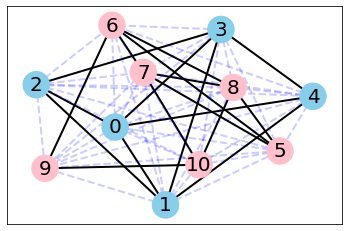

In [53]:
#
# https://networkx.github.io/documentation/networkx-1.9/examples/drawing/weighted_graph.html
#
pos = nx.spring_layout(G)

threshold = 1.25
elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > threshold]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <= threshold]

node_colors = [get_node_color(i) for (i, _) in enumerate(texts)]
nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors)
nx.draw_networkx_edges(G,pos,edgelist=elarge, width=2)
nx.draw_networkx_edges(G,pos,edgelist=esmall, width=2, alpha=0.2, edge_color='b', style='dashed')
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')

This graph gives us the ability to look out for strongly connected components using the weights feature, and identify patterns in our documents. What patterns can you see in our graph here, and what might that tell you about our documents, as well as our topic model? Such visualisations are a useful diagnostic tool to check if our method of representations (i.e topic models, neural models) make intuitive sense, by comparing differences between our objects represented. In this case, we adapated a topic model for the visualisation, but you can use a similar set up for any set of objects and metrics. This is useful to think about for your HW!

### Examples of distances on real-world distributions and embeddings

Now that we've seen a bunch of different measures and how they work on topic models, we will now expand our analysis to other forms of distributions and representations. In this section, we will create different kinds of vector representations of the same object - in this case, words. As we will see in our section on integrating and aligning embeddings, one way to align objects is by choosing different representations of the same object and explore their relationships. 

We will lay some groundwork for this kind of analysis here by first creating word2vec embeddings for 4 words associated with cooking and cleaning.

In [54]:
import gensim

In [55]:
from gensim.models import Word2Vec


### If using Google Colab:

In [69]:
#from google.colab import drive
#drive.mount('content/drive')

In [70]:
model_address = "content/nytimes_cbow.reduced.txt"

In [144]:
model_address = "content/GoogleNews-vectors-negative300.bin"

In [146]:
google_w2v_model = gensim.models.KeyedVectors.load_word2vec_format(model_address, binary=True
                                                                   )

In [147]:
spoon_vector = google_w2v_model["spoon"]

In [148]:
plunger_vector = google_w2v_model["plunger"]

In [149]:
spatula_vector = google_w2v_model["spatula"]

In [150]:
soap_vector = google_w2v_model["soap"]

In [151]:
spoon_vector[0:8]

array([-0.06079102, -0.05859375,  0.20507812, -0.10253906, -0.19726562,
       -0.13769531,  0.28320312, -0.0004673 ], dtype=float32)

In [152]:
word_vectors = {"spoon":spoon_vector, "plunger":plunger_vector, "spatula":spatula_vector, "soap":soap_vector}

So now that we have a dictionary mapping words to their embeddings, we can use this later for distance analysis.

For fun, let's also use each of these word's color distributions($J_zA_zB_z$) to see how they match up. (We came across comp-syn and ($J_zA_zB_z$)  vectors in the last notebook). We note that this investigation is another take on representational difference. In case you are not using compsyn, you can try out these distance metrics using other inputs, such as word vectors. Note that to use comp-syn you must first download the [($J_zA_zB_z$) numpy array](https://drive.google.com/file/d/1wspjIBzzvO-ZQbiQs3jgN4UETMxTVD2c/view) and upload it to your files for the colab session.

One of the main powers of comp-syn is the pre-loaded color distribution vectors they have for 40,000 commonly used english words. You will need to download these two files first, and upload it in the files section.

1) [vectors.json](https://drive.google.com/file/d/1edQaibCW9yCih_pVeeYZWzPlgNZJ4Fzp/view?usp=sharing)
2) [concreteness-color-embeddings.json](https://drive.google.com/file/d/1edQaibCW9yCih_pVeeYZWzPlgNZJ4Fzp/view?usp=sharing)

Let's do a recap on what these color distribution vectors do. The [comp-syn](https://github.com/comp-syn/comp-syn) package allows you to aggregate images associated with a word, and create an **average image representation associated with words**. This can be done either using a popular Image-Word dataset such as ImageNet, or by aggregating images through a search engine such as Google Image Search. The default, pre-loaded word-color vectors associated with comp-syn are created by extracting the top 100 images returned from a google image search result, creating a $J_zA_zB_z$ representation of those images, and averaging these representations, followed by a histogram binning to convert the distribution of values for pixels into a lower dimensional representation. We saw some of these teachniques applied to individual images - now, we use the end-product. 

We can think of these word-color vectors as a dense representation of the average image (specifically color composition and lighting) represenation of words. For example, an apple might have mostly red, with some green, and trees may be mostly brown and green. The work by the [comp-syn](https://comp-syn.com/#/) team ([Guilbeault et al, 2020](https://www.sciencedirect.com/science/article/abs/pii/S0010027720301256), [Srinivasa Desikan et al, 2020](https://www.aclweb.org/anthology/2020.coling-main.154/)) explores the many ways we can use these word-color vectors for exploration of multi-modal meaning generation and semantics. 

In the following lines of code, we load the pre-existing word-color vectors for the same words we used earlier for word embeddings. 

In [160]:
!pip install compsyn

In [161]:
import compsyn as cs
import PIL
from PIL import Image
import numpy as np

In [174]:
path = "/content/"

In [178]:
disk_vectors = cs.vectors.LoadVectorsFromDisk(path)

In [ ]:
spoon_rgb = disk_vectors.vectors["spoon"].rgb_dist

In [ ]:
spoon_jzazbz = disk_vectors.vectors["spoon"].jzazbz_dist

In [ ]:
plunger_rgb = disk_vectors.vectors["plunger"].rgb_dist

In [ ]:
plunger_jzazbz = disk_vectors.vectors["plunger"].jzazbz_dist

In [ ]:
soap_rgb = disk_vectors.vectors["soap"].rgb_dist

In [ ]:
soap_jzazbz = disk_vectors.vectors["soap"].jzazbz_dist

In [ ]:
spatula_rgb = disk_vectors.vectors["spatula"].rgb_dist

In [ ]:
spatula_jzazbz = disk_vectors.vectors["spatula"].jzazbz_dist

In [179]:
spoon_jzazbz

In [180]:
rgb_vectors = {"spoon_rgb":spoon_rgb, "plunger_rgb":plunger_rgb, "spatula_rgb":spatula_rgb, "soap_rgb":soap_rgb}

In [181]:
jzazbz_vectors = {"spoon_j":spoon_jzazbz, "plunger_j":plunger_jzazbz, "spatula_j":spatula_jzazbz, "soap_j":soap_jzazbz}

So we now have dense representations of the average image associated with a word, using both RGB and the perceptually uniform $J_zA_zB_z$ color spaces. The default vectors loaded have been binned into 8 dimensions, and we can think of these dimensions as capturing the key color and lighting attributes of the images associated with the word. While RGB only focuses on the three primary color channels, the $J_zA_zB_z$ captures more human perceptual information in its color space.

So we now have word embeddings, $J_zA_zB_z$ embeddings, and RGB embeddings associated with words. The color embeddings are essentially distributions of color, so we can use some of the measures we previously saw on them. 

In this section, we will be creating heatplots to visualise distances between these representations, trying out different measurements.

In [77]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [78]:
def heatplot(ps, qs, distance_function, annot=True):
    # inputs are dictionaries with object -> data point
    L = []
    for p in ps:
        l = []
        for q in qs:
            l.append(distance_function(ps[p], qs[q]))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(ps.keys()), index = list(qs.keys()))
    ax = sns.heatmap(div, annot=annot)
    plt.show()

In [182]:
heatplot(word_vectors, word_vectors, cosine_distance)

We see that spatula and spoon are close by (both to do with cooking), are close by, and pretty much all the other words are fairly different from each other. Let's see if their color distributions are similar or not.

In [ ]:
heatplot(jzazbz_vectors, jzazbz_vectors, kullback_leibler)

We see here that $D_{KL}$ lacks symmetry and can make these a little difficult to interpret - let us use the symmetric $D_{JS}$, which averages between the two directions of the $D_{KL}$. We still some structure and similarities, let's see what JS looks like.

#### Jensen Shannon Divergence - Heatplot

In [ ]:
heatplot(jzazbz_vectors, jzazbz_vectors, jensen_shannon)

We see some interesting relations here which suggest that our color vectors are in some case similar, but in some cases quite different in capturing relationships! For example, a spatula and spoon are similarly close in both word2vec and $J_zA_zB_z$, but soap and spatula are also very close in $J_zA_zB_z$ space unlike word2vec. This must mean that they share some visual or color related content. What is especially striking is how similar the spatula and plunger representations are in this space, as opposed to the word embedding space where it was not close at all. 

This matches up to our intuitions - spatulas and plungers are semantically quite different, but they have similar shapes and colors in their images (specifically here, in their dense representations of colors).

#### Wasserstein Distance or Earth Movers Distance- Heatplot

Now let's explore the same with the Wasserstein Distance.


In [ ]:
heatplot(jzazbz_vectors, jzazbz_vectors, wasserstein_distance)

Let's try the same metric on our word embeddings too.

In [ ]:
heatplot(word_vectors, word_vectors, wasserstein_distance)

We see a key difference in the closes objects in this space - for $J_zA_zB_z$ vectors, the spatula and the spoon are very similar, but for word vectors, it seems to be the spoon and soap vectors. This doesn't quite track intuitively, because we would expect spoon and spatula to be the closest word2vec embeddings, which we saw in the cosine distance heatplot. 

This is part of the process of troubleshooting while finding your ideal metric. You choose a subset of your dataset where you have a clear expectation or label, and use metrics to see which one reflects your expectations best. You can then scale this method to a larger dataset (for e.g in this case, a large vocabulary of words). 

### Audio and Network Examples of Distances

We saw a bunch of distance metrics applied to words, as distributional semantics based word2vec, and human perceptual color averages. Both of these representations are amenable to distance measures, and in this section we will continue our exploration with representations of networks and audio.

Let's use the Karate Club network example we saw in the previous notebook. We use node2vec to represent individual nodes in this network. [node2vec](https://arxiv.org/abs/1607.00653) (Grover and Lescovec, 2016). Intuition of the algorithm: Find embedding of nodes to ddimensions so that “similar” nodes in the graph have embeddings that are close together.

In [80]:
import networkx as nx

In [81]:
karate_club_graph = nx.karate_club_graph()

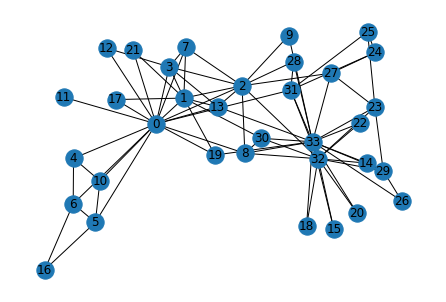

In [82]:
nx.draw(karate_club_graph, with_labels=True)

In [83]:
!pip install node2vec

In [84]:
from node2vec import Node2Vec

In [85]:
node2vec = Node2Vec(karate_club_graph, dimensions=64, walk_length=30, num_walks=200, workers=4)  # Use temp_folder for big graphs

Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

In [86]:
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [87]:
node_vectors = {}

In [88]:
for i in range(0, len(karate_club_graph)):
  node_vectors[i] = model.wv.get_vector(str(i))


Let's peak at two of the nodes.

In [89]:
node_vectors[0], node_vectors[30]

(array([ 0.03308497,  0.04498833,  0.00031758, -0.08733435,  0.03412487,
        -0.05625009,  0.01504823,  0.29740697, -0.06648648, -0.0162882 ,
         0.2825403 , -0.02114408,  0.13828215,  0.13555041, -0.10150182,
        -0.16284366, -0.20655425,  0.12274425,  0.00926396,  0.21817835,
         0.0898933 , -0.04409502,  0.1514708 , -0.20407619, -0.16117553,
         0.2248257 , -0.21901149, -0.02506842, -0.05035712, -0.00642953,
         0.08824629,  0.08428369, -0.18857507, -0.13559537,  0.11356436,
         0.27232274, -0.07608704,  0.16156422,  0.0755311 ,  0.07678487,
         0.04412263,  0.08079869, -0.12089518, -0.01486277, -0.14229932,
        -0.05916173, -0.00823851, -0.19038874, -0.08386223,  0.23588903,
         0.0486664 ,  0.25170636,  0.16066143,  0.11100952,  0.13248374,
         0.14435492,  0.1979179 , -0.137354  ,  0.1417283 , -0.20389356,
         0.17530608, -0.0914153 , -0.24887843,  0.08641985], dtype=float32),
 array([ 0.09385359, -0.00883211,  0.12028497, 

In [90]:
node_subset_0 = {key: value for key, value in node_vectors.items() if key < 4}

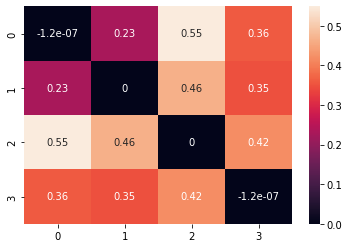

In [91]:
heatplot(node_subset_0, node_subset_0, cosine_distance)

In [92]:
node_subset_1 = {key: value for key, value in node_vectors.items() if key > 29}

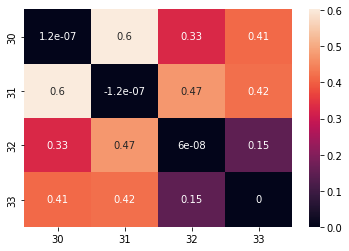

In [93]:
heatplot(node_subset_1, node_subset_1, cosine_distance)

The closes pairs in each of these heatplots are (0, 1) and (32, 33). Go back and peak at the network - you can see that these nodes seem to have similar structure! So this measure makes sense.

Let's now choose a radically different measure, kolmogorov_smirnov, which we saw earlier in the notebook, which is often used as a statistic of similarity between two distributions of data. 

In [94]:
def kolmogorov_smirnov(dist_1, dist_2):
  return(ks_2samp(dist_1, dist_2)[0])

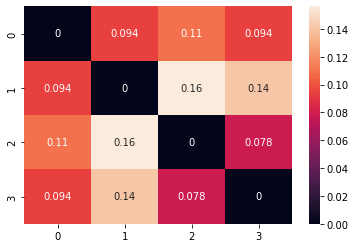

In [95]:
heatplot(node_subset_0, node_subset_0, kolmogorov_smirnov)

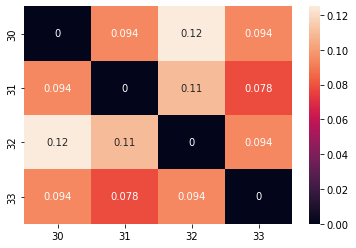

In [96]:
heatplot(node_subset_1, node_subset_1, kolmogorov_smirnov)

While we see some aspects aee similar to cosine, node 0 is closer to node 2 and node 3, which we would need to dive deeper into to investigate. It also brings up some other questions - what would similarity in a network mean between nodes? Between edges? 

In the homework these are some of the questions you will be exploring. 

In [97]:
from node2vec.edges import HadamardEmbedder

In [98]:
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

In [99]:
edges_embs[('24', '25')]

array([ 2.3938565e-02, -2.9601383e-03,  4.5003992e-02, -2.1398321e-03,
       -3.1137484e-04,  2.6100369e-02,  5.1569298e-04,  2.0531071e-02,
        5.5557493e-02, -3.3663139e-03,  1.2932235e-02,  5.6223914e-02,
       -6.1098989e-03,  3.9783055e-03,  3.0544516e-02,  3.2282807e-02,
        3.6303177e-03,  3.9453313e-02,  5.4300938e-02,  2.1674894e-01,
        6.8314519e-04,  3.6499321e-02,  1.8658231e-03,  4.5019332e-02,
        1.6126705e-02,  9.3492325e-03,  3.1142434e-02,  5.2393992e-02,
        6.5798028e-03,  8.9415953e-02,  1.0401064e-02,  1.0471112e-02,
        8.8189028e-02,  5.9717855e-05,  3.0313956e-03,  3.7486650e-02,
        8.2329802e-02,  5.6760177e-02,  5.3060424e-02,  2.3565961e-02,
       -2.7546787e-03,  3.2056402e-02,  1.0965878e-01,  4.9380362e-02,
        3.4223340e-02,  2.4288397e-02,  3.4569677e-02,  9.4321690e-02,
        3.0653538e-02, -1.0763410e-02,  9.6828878e-02, -6.4777830e-03,
       -5.9615535e-04,  5.3991958e-02,  1.0729928e-01,  3.6506334e-04,
      

In [100]:
edges_embs[('0', '1')]

array([-1.3877049e-03, -8.3110511e-04, -4.1289648e-05, -9.2110950e-03,
        2.7215204e-04,  6.8109734e-03,  3.0417047e-03,  7.1805701e-02,
        1.6560681e-02, -2.6329863e-04,  7.0108704e-02, -5.3625670e-04,
        4.4975248e-03,  5.2006408e-03,  1.0464047e-03,  1.4666598e-02,
        2.7267330e-03,  1.2534475e-02, -1.0676585e-04,  4.7001850e-02,
        1.7931817e-02, -8.1498915e-04,  2.1857878e-02,  2.1741157e-02,
       -4.5017414e-03,  7.5937575e-04,  3.8169201e-02,  1.4733265e-03,
        2.7597933e-03,  8.8562118e-04,  6.2343031e-03,  4.7219479e-03,
        7.1886927e-03,  1.8177953e-02,  3.8758819e-03,  1.0700315e-01,
        2.6900077e-03,  7.5071407e-03,  1.3102195e-02,  6.2922882e-03,
        6.6868374e-03,  5.0422805e-03,  3.0694160e-04,  7.0683489e-04,
        3.2451827e-02,  2.5125809e-03,  9.1221544e-04,  2.2267748e-02,
       -3.3183610e-03,  4.1286357e-02,  4.9766540e-03,  8.1747904e-02,
        5.9294216e-02,  2.8815675e-03,  2.8120037e-02,  3.3703838e-03,
      

You can similarly create a dictionary of such edge embeddings and measure similarities.

Let us now look at audio embeddings.

In [101]:
!pip install transformers

In [102]:
!pip install datasets

In [103]:
import soundfile as sf
import torch

In [104]:
from transformers import Wav2Vec2Tokenizer, Wav2Vec2Model, Wav2Vec2Processor

In [105]:
# load pretrained model
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
C:\Users\parth\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\wav2vec2\tokenization_wav2vec2.py:421: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model

Downloading:   0%|          | 0.00/159 [00:00<?, ?B/s]

In [106]:
from datasets import load_dataset

In [107]:
def map_to_array(batch):
    speech, _ = sf.read(batch["file"])
    batch["speech"] = speech
    return batch

In [108]:
ds = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")
ds = ds.map(map_to_array)

Reusing dataset librispeech_asr (C:\Users\parth\.cache\huggingface\datasets\patrickvonplaten___librispeech_asr\clean\2.1.0\f2c70a4d03ab4410954901bde48c54b85ca1b7f9bf7d616e7e2a72b5ee6ddbfc)
Loading cached processed dataset at C:\Users\parth\.cache\huggingface\datasets\patrickvonplaten___librispeech_asr\clean\2.1.0\f2c70a4d03ab4410954901bde48c54b85ca1b7f9bf7d616e7e2a72b5ee6ddbfc\cache-c39f3c102fe014b8.arrow


In [109]:
audio_input_0 = ds["speech"][0]

In [110]:
input_values = processor(audio_input_0, return_tensors="pt").input_values  # Batch size 1

It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


In [111]:
input_values

tensor([[0.0386, 0.0337, 0.0322,  ..., 0.0070, 0.0095, 0.0169]])

In [112]:
len(input_values[0])

93680

In [113]:
hidden_states_asr = model(input_values).last_hidden_state

In [118]:
hidden_states_asr.shape

torch.Size([1, 292, 768])

In [120]:
# load audio
audio_input_english, _ = sf.read("content/english.wav")

In [122]:
input_values = processor(audio_input_english, return_tensors="pt").input_values  # Batch size 1

It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


In [123]:
len(input_values[0])

408226

In [124]:
hidden_states_english = model(input_values).last_hidden_state

In [125]:
hidden_states_english.shape

torch.Size([1, 1275, 768])

In [126]:
498226 / 174160

2.8607372531005972

In [127]:
1275 / 544

2.34375

What have we done here so far? We picked up two different wave files, one from a pre-trained corpus on speech recognition from librispeech, and the other from an audio file which we used in tutorial 2.1. 

We then processed them using the transformers wav2vec2 tokenizer, and then passed them through the model, which returned us the hidden states - we can see here that the hidden states are different shapes, with the size of the audio file influencing the shape of the hidden states. This means that the output size depends on the input, and we must do something to keep them all the same size (or use similar length files). 

One quick way to get them ready to use for analysis is to create an "average" vector. 

In [128]:
avg_hidden_states_asr = torch.mean(hidden_states_asr[0], dim=0).detach().numpy()

In [129]:
avg_hidden_states_asr.shape

(768,)

In [130]:
avg_hidden_states_english = torch.mean(hidden_states_english[0], dim=0).detach().numpy()

In [131]:
avg_hidden_states_english.shape

(768,)

Neat, now that we have both down to an average vector, let's calculate the difference.

In [132]:
cosine_distance(avg_hidden_states_english, avg_hidden_states_asr)

0.5999834537506104

So these embeddings are fairly different - but to be able to really tell how useful these embeddings are, we must compare with a third source. Let's whip up a quick function to get average embeddings.

In [133]:
def average_audio_embedding(audio_path):
  audio_input, _ = sf.read(audio_path)
  input_values = processor(audio_input, return_tensors="pt").input_values  # Batch size 1
  if input_values.shape[2] == 2:
    input_values = input_values[:,:,:1].reshape(1, input_values.shape[1])
  hidden_states = model(input_values).last_hidden_state
  avg_hidden_state = torch.mean(hidden_states[0], dim=0).detach().numpy()
  return avg_hidden_state

I downloaded the 30 free country music samples from [stayonbeat.com](https://www.stayonbeat.com/2014/01/13/free-country-music-loops/), and uploaded a couple on to Colab to see how what the embeddings look like. You are also encouraged to do the same or use your own music.

In [134]:
sample_path_1 = "/content/StayOnBeat.com_CountryLoops_1.wav"

In [138]:
sample_1_embedding = average_audio_embedding(sample_path_1)

In [139]:
sample_path_2 = "/content/StayOnBeat.com_CountryLoops_2.wav"

In [140]:
sample_2_embedding = average_audio_embedding(sample_path_2)

In [ ]:
audio_vectors = {"english":avg_hidden_states_english, "asr":avg_hidden_states_asr, "country_sample_1":sample_1_embedding, "country_sample_2":sample_2_embedding}

In [ ]:
heatplot(audio_vectors, audio_vectors, cosine_distance)

Interesting - we see that the two country samples are very similar to each other, but funnily enough the two speech tracks are more similar to the country samples compared to each other! 

In the HW you will be exploring more of these embeddings and their distances.

# Integrating and Aligning Data and Embeddings 

This section will explore methods aligning data and embeddings. At first, we will not be traning deep learning models based on multi-modal data, but rather using different representations and embeddings--which may have been generated within the hidden layers of an effective neural network model--and seeing how we can align or integrate them through simple stacking or more sophisticated alignment (e.g., procrustes). 

## Aligning Diverse Data Types

Another approach is to align concepts across their multiple representations and modes of perception. For example, according to distributional semantics, words acquire their meaning from the company they keep, and the word2vec method uses this as its theoretical motivation.

#### Words as semantic content

In [183]:
word_vectors["spoon"]

array([-6.07910156e-02, -5.85937500e-02,  2.05078125e-01, -1.02539062e-01,
       -1.97265625e-01, -1.37695312e-01,  2.83203125e-01, -4.67300415e-04,
       -1.87500000e-01, -1.01470947e-03, -2.42187500e-01, -1.69677734e-02,
        2.02148438e-01,  8.34960938e-02, -1.72851562e-01,  1.37695312e-01,
       -2.03125000e-01, -5.98144531e-02, -2.67578125e-01, -2.77343750e-01,
        2.44140625e-01,  2.41210938e-01,  4.31640625e-01,  1.04370117e-02,
        1.34765625e-01, -1.86523438e-01, -1.05957031e-01,  2.50000000e-01,
       -1.73828125e-01,  1.27929688e-01, -8.39843750e-02,  3.68652344e-02,
        2.52685547e-02, -1.28906250e-01,  9.37500000e-02,  2.14843750e-01,
        2.07031250e-01,  2.53906250e-01, -5.95703125e-02,  1.45507812e-01,
        9.22851562e-02,  3.08227539e-03,  4.33593750e-01, -1.18164062e-01,
        3.90625000e-01, -3.78417969e-02, -1.33789062e-01,  1.19628906e-01,
        4.96093750e-01,  6.29882812e-02, -2.92968750e-01, -7.41577148e-03,
       -1.26953125e-01, -

In [184]:
word_vectors["spatula"]

array([-0.19140625, -0.04296875,  0.27539062,  0.00488281, -0.3203125 ,
        0.08203125,  0.05566406, -0.03613281, -0.31445312,  0.10693359,
       -0.359375  ,  0.29882812,  0.02331543,  0.05517578, -0.140625  ,
        0.1953125 , -0.23632812, -0.22167969, -0.06542969, -0.3359375 ,
        0.25195312, -0.09326172,  0.54296875,  0.11328125, -0.28710938,
       -0.12011719, -0.11181641,  0.20996094, -0.33203125,  0.30273438,
       -0.3359375 , -0.12255859,  0.12890625, -0.28515625, -0.04223633,
        0.25585938,  0.3203125 ,  0.07177734,  0.19042969, -0.01379395,
        0.16992188, -0.22460938,  0.5078125 ,  0.08398438, -0.07519531,
       -0.06396484,  0.05371094,  0.34570312,  0.46289062, -0.16699219,
       -0.30664062,  0.15234375, -0.09765625, -0.26171875, -0.14160156,
        0.2265625 ,  0.49609375, -0.10791016, -0.08447266,  0.234375  ,
        0.04931641, -0.07128906,  0.05273438, -0.11914062,  0.09814453,
        0.11181641, -0.13574219, -0.46875   ,  0.26171875,  0.12

#### Words as Images and Color

Words have meaning associated to them, and this meaning is formed in many ways. The previous method we saw, word2vec, is based on the notion of "distributional semantics", which means that words get their meaning based on how they are distributed, i.e what kind of words appear around each other. Words like spoon appear around words like spatula and ladle, and maybe lie in a "semantic kitchen", of sorts. But words don't just get their meaning through other words, they also get their meaning through the embodied aspects of human experience, such as vision or sound. 

Work in multi-modal theories of cognition and joint embeddings allow us to represent words using mulitple data sources. We've seen how the package [comp-syn](https://github.com/comp-syn/comp-syn/) lets us load both average images and color vectors for words. Let's now look at some representations of spoon, measured in different notions of color. 

To run the colorgram lines of code, download the spoon, soap, spatula and plunger colorgram from this [Google Drive Folder](https://drive.google.com/drive/folders/1rph83P4sWvLTfsnq5TbaISLzD5cmlXF7?usp=sharing) (an average word representation by aggregating images). Once you download the colorgrams you wish to inspect, you must create a folder titled "colorgrams", and upload your image there.

Here, the colorgram serves as an **average image representation of a word**, where it can visually serve as the aggregate representation a word in a dataset or image search. That's why the spoon and spatula colorgrams have that look to them, and this average image is what we use to extract color and lightness information from. We have already seen what these dense RGB and $J_zA_zB_z$ vectors function like in our initial experiments on using distance metrics on them. In fact, comparing between the same concept (here, words) in different semantic spaces and studying their differences is a form of aligning data representations.

In the following code we will more explicity look at these representations along with the visual aid of the colorgram.

In [186]:
disk_vectors.load_colorgram("spoon")

In [ ]:
disk_vectors.vectors["spoon"].colorgram

In [ ]:
disk_vectors.vectors["spoon"].rgb_dist

In [ ]:
disk_vectors.vectors["spoon"].jzazbz_dist

Similarly, the other words we used, spatula, plunger and soap, have corresponding RGB and 𝐽𝑧𝐴𝑧𝐵𝑧  dense representations. Let's have a quick peak at the last 3 colorgrams.

In [ ]:
disk_vectors.load_colorgram("spatula")

In [ ]:
disk_vectors.vectors["spatula"].colorgram

In [ ]:
disk_vectors.load_colorgram("soap")

In [ ]:
disk_vectors.vectors["soap"].colorgram

In [ ]:
disk_vectors.load_colorgram("plunger")

In [ ]:
disk_vectors.vectors["plunger"].colorgram

Visualising these average images helps us understand what is being condensed in the vectors we have access to. Let's now go a step further.

## Words as seen as images by a CNN

So in the above few cells we see an average image, and average color distributions. This tells us the shape and color information associated with the word. We can use this average image for other purposes, such as creating an image embedding of the colorgram. So we are going from

word -> average image of word -> CNN embedding of this image.

Such a representation may be useful in accessing multi-modal insights into words and texts.

In [ ]:
!pip install img2vec_pytorch

In [ ]:
from img2vec_pytorch import Img2Vec

In [ ]:
img2vec = Img2Vec()

In [ ]:
avg_spoon = disk_vectors.vectors["spoon"].colorgram

In [ ]:
spoon_img_vec = img2vec.get_vec(avg_spoon)

In [ ]:
len(spoon_img_vec)

In [ ]:
spoon_img_vec[0:100]

So what is this 512 dimensional vector? It is the internal representation which a image classification CNN makes before making a class prediction (i.e is it a cat, spoon, car, etc). So we have in this vector some notion of the properties of an image which allow it to be easily classified into an object or category. 

Let us create representations of this for our words as well and try some distance measures.

In [ ]:
avg_soap = disk_vectors.vectors["soap"].colorgram
soap_img_vec = img2vec.get_vec(avg_soap)

In [ ]:
avg_plunger = disk_vectors.vectors["plunger"].colorgram
plunger_img_vec = img2vec.get_vec(avg_plunger)

In [ ]:
avg_spatula = disk_vectors.vectors["spatula"].colorgram
spatula_img_vec = img2vec.get_vec(avg_spatula)

In [ ]:
word_image_cnn_vecs = {"spoon_cnn":spoon_img_vec, "plunger_cnn":plunger_img_vec, "spatula_cnn":spatula_img_vec, "soap_cnn":soap_img_vec}

Ok, let's do a brief re-cap. We have 3 different ways of representing these 4 words. Word embeddings (word2vec), Color embeddings (via avg of 100 images of that word using 𝐽𝑧𝐴𝑧𝐵𝑧), Image embedding (via avg of 100 images of that word using a CNN). Each of these embeddings capture a different aspect of the semantics of a word.

Let us see, once more, how standard distance measures explore between these representations. We have already seen these for word and color, but we will do them again to contrast with all 3 forms.


In [ ]:
heatplot(word_vectors, word_vectors, cosine_distance)

In [ ]:
heatplot(jzazbz_vectors, jzazbz_vectors, jensen_shannon)

In [ ]:
heatplot(word_image_cnn_vecs, word_image_cnn_vecs, cosine_distance)

It is interesting to see that the spatula and the spoon are similar in all of these spaces. This means that there is a strong alignment in both the semantic and visual content. In other spaces, this is different - for example, the spoon and plunger are far away in a word embedding space (intuitively this matches up), but similar in image spaces - which makes sense in terms of the average image being created, where the images of plumbers and spoons have similar color distributions and shape. Here, we can think of the CNN extracting shape similarities - identifying the shape in local structures is one of the benefits of CNNs for image analysis. 

So we've seen here an aligning which is conceptual - we are creating representations for the same object / concept ("spoon"), using various approaches and aligning them by concept or shape or color. We can then conduct analysis in multiple ways. For example, we may want to cluster all of our collections of word vectors to see how different domains cluster in different ways. What does shape or color bring together that distributional semantics cannot? Another way we can conduct analysis using multiple representations is using them to explore a concept, such as abstract or concrete concepts, or literal or metaphors. The work *comp-syn: Perceptually Grounded Word Embeddings with Color* ([Srinivasa Desikan et al, 2020](https://www.aclweb.org/anthology/2020.coling-main.154/)) explores these concepts using these embeddings. 

## Aligning Similar Data Types Data After Embedding

Aligning similar data types is possible in situations where there are natural oppurtunities of alignment - two examples we will explore in this section are word embedding alignment across time, and word embedding alignment across languages. Note that in this case, we are using only word embeddings, though in principle these alignment methods can extend to situations when the same objects (here they are words) appear in two different settings (here they are times/languages). 

### Cross Temporal Alignment

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic chanage as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf). 

In this case we are training the models ourselves instead of using a pre-trained model, so this might take some time.

In [6]:
!pip install git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git


  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to c:\users\parth\appdata\local\temp\pip-req-build-36v4z149
Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(CertificateError("hostname 'pypi.org' doesn't match 'ucwn.uchicago.edu'"))) - skipping


  Running command git clone --filter=blob:none --quiet git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git 'C:\Users\parth\AppData\Local\Temp\pip-req-build-36v4z149'
  fatal: unable to connect to github.com:
  github.com[0: 140.82.114.3]: errno=Unknown error

  error: subprocess-exited-with-error
  
  git clone --filter=blob:none --quiet git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git 'C:\Users\parth\AppData\Local\Temp\pip-req-build-36v4z149' did not run successfully.
  exit code: 128
  
  See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

git clone --filter=blob:none --quiet git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git 'C:\Users\parth\AppData\Local\Temp\pip-req-build-36v4z149' did not run successfully.
exit code: 128

See above for output.

note: This error originates from a subprocess, and is likely not a problem w

In [7]:
import lucem_illud

In [8]:
import gensim

In [9]:
import pandas

In [10]:
import copy

In [11]:
import sklearn

In [12]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.vectors / np.sqrt((model.wv.vectors ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.

    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # patch by Richard So [https://twitter.com/richardjeanso) (thanks!) to update this code for new version of gensim
    # base_embed.init_sims(replace=True)
    # other_embed.init_sims(replace=True)

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the (normalized) embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs)
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v)
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)

    return other_embed

def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key

        print(len(m.wv.key_to_index), len(m.wv.vectors))

    return (m1,m2)

In order to explore this, let's get some data that follows a time trend. We'll look at conference proceedings from the American Society for Clinical Oncologists. You can download the data [here](https://drive.google.com/file/d/1R9EiThdJQ3vY84xcoPJGUBeqvemu_o8L/view?usp=sharing).

In [13]:
ascoDF = pandas.read_csv("content/ASCO_abstracts.csv", index_col=0)

In [15]:
ascoDF['tokenized_sents'] = ascoDF['Body'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
ascoDF['normalized_sents'] = ascoDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

C:\Users\parth\AppData\Local\Programs\Python\Python39\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [16]:
def compareModels(df, category, sort = True):
    """If you are using time as your category sorting is important"""
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF['normalized_sents'].sum())
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [17]:
rawEmbeddings, comparedEmbeddings = compareModels(ascoDF, 'Year')

159 159ng 2011
159 159
117 117
117 117
100 100
100 100
94 94
94 94
91 91
91 91
91 91
91 91
91 91
91 91
89 89
89 89
89 89
89 89
87 87
87 87
86 86
86 86
85 85
85 85
83 83
83 83
82 82
82 82
25 25
25 25
117 117
117 117
100 100
100 100
94 94
94 94
91 91
91 91
89 89
89 89
87 87
87 87
86 86
86 86
85 85
85 85
83 83
83 83
82 82
82 82
25 25
25 25
94 94
94 94
94 94
94 94
91 91
91 91
89 89
89 89
87 87
87 87
86 86
86 86
85 85
85 85
83 83
83 83
82 82
82 82
25 25
25 25
91 91
91 91
91 91
91 91
89 89
89 89
87 87
87 87
86 86
86 86
85 85
85 85
83 83
83 83
82 82
82 82
25 25
25 25
89 89
89 89
89 89
89 89
89 89
89 89
89 89
89 89
87 87
87 87
86 86
86 86
85 85
85 85
83 83
83 83
82 82
82 82
25 25
25 25
87 87
87 87
87 87
87 87
87 87
87 87
87 87
87 87
87 87
87 87
86 86
86 86
85 85
85 85
83 83
83 83
82 82
82 82
25 25
25 25
85 85
85 85
85 85
85 85
85 85
85 85
85 85
85 85
85 85
85 85
85 85
85 85
83 83
83 83
82 82
82 82
25 25
25 25
82 82
82 82
82 82
82 82
82 82
82 82
82 82
82 82
82 82
82 82
82 82
82 82
82 82
82 82
2

In [44]:
comparedEmbeddings[1995][0].wv['breast']

array([ 0.00605464, -0.00058399,  0.00689745, -0.00591011,  0.00370008,
       -0.00435802,  0.00494689,  0.00224411,  0.0006639 , -0.00820599,
       -0.00381012, -0.0086963 , -0.00436083,  0.00201249, -0.00274967,
        0.00462188, -0.01042378, -0.00754793, -0.01035913, -0.01517018,
        0.0035142 , -0.0048537 ,  0.00980552, -0.00258724, -0.00603063,
       -0.00064028,  0.00608514, -0.00514922, -0.00740336,  0.00113341,
       -0.00345097,  0.00702479,  0.00236786,  0.00728944, -0.01365445,
        0.00678819,  0.0030536 , -0.0070729 , -0.00046694, -0.01865489,
       -0.0047306 , -0.00571571,  0.00889246, -0.00702597, -0.00290905,
       -0.00044734, -0.0086669 ,  0.002644  ,  0.00646119,  0.0080013 ,
        0.00225429,  0.0052521 , -0.00121492, -0.00112227,  0.01067049,
        0.01982297,  0.00738447,  0.00147008, -0.00705093,  0.00485715,
       -0.00072927, -0.00896363, -0.0078556 , -0.01004775, -0.00171488,
        0.01263295,  0.0006705 ,  0.00805472, -0.01142707,  0.00

This is the key to our aligning - the smart procrustes align method here is the one doing the aligning, and we are adding the alligned embeddings to the dictionary.

We need to compare them across all permutations so we will define another function to help, we will be using 1 - cosine similarity as that gives a more intitive range of 0-2 with low values meaning little change and high meaning lots of change.

In [40]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(embeddingsDict[cat][0].wv[word].reshape(1, -1),
                                                                             embed.wv[word].reshape(1, -1))[0,0]))
    return pandas.DataFrame(dists, index = cats)

In [41]:
import matplotlib.pyplot as plt

In [42]:
import seaborn

We now check certain words and see their movement in time along these abstracts.

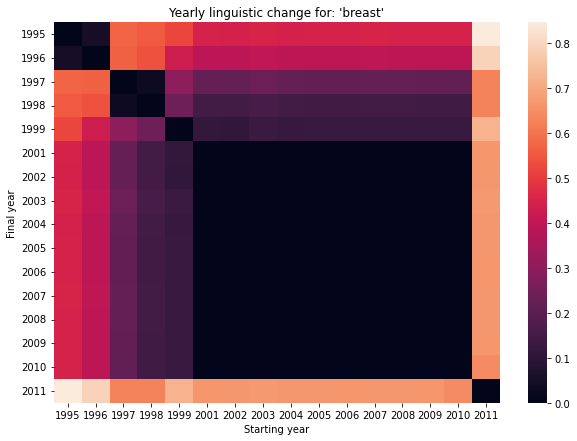

In [43]:
targetWord = 'breast'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()


In [ ]:
targetWord = 'combination'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [51]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(embeddingsDict[cats[0]][0].wv[word].reshape(1, -1), embed.wv[word].reshape(1, -1))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.key_to_index.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [52]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 25 words to compare


In [53]:
wordDivergences[:20]

[('progression', 7.245801091194153),
 ('breast', 7.024854749441147),
 ('status', 6.663868099451065),
 ('results', 6.142989486455917),
 ('studies', 5.731075674295425),
 ('study', 5.614664271473885),
 ('overall', 5.600038900971413),
 ('months', 5.473989516496658),
 ('treatment', 5.446790009737015),
 ('efficacy', 5.444278042763472),
 ('iii', 5.349613264203072),
 ('significant', 5.272614613175392),
 ('analysis', 5.211592027917504),
 ('data', 4.935688093304634),
 ('tumor', 4.725933026522398),
 ('therapy', 4.6270617842674255),
 ('response', 4.291807666420937),
 ('phase', 4.035701479762793),
 ('years', 3.83452320843935),
 ('median', 3.1791884303092957)]

In [ ]:
wordDivergences[-20:]

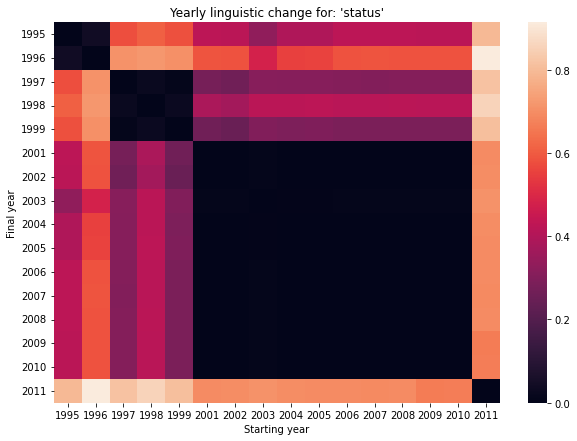

In [54]:
targetWord = wordDivergences[2][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

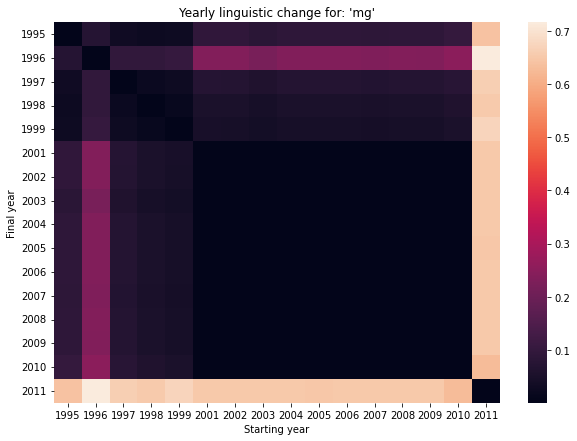

In [55]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

We've seen here from a small, research based corpus how it is still able to capture some notion of semantic drift. The word cell has moved among the most and the word view has moved the least. We recommend trying similar analysis on different datasets to see how words change their meaning over time based on the company they keep. 

### Cross lingual alignment

While in the previous example we saw how we can use a time-stamped textual corpus to create embe"ddings and then compare between them, in the following example we use pre-trained embeddings for different languages and align them using some powerful packages built for just doing that.

Here, we will use Fast Text word embeddings downloaded from their [documentation website](https://fasttext.cc/), for Spanish and French embeddings. You must download these embeddings and upload them to be able to do this part of the exercise. Note that these files are kind of large! If it doesn't work, restart your session, clear your uploads and try this section again.

We then perform an SVD and orthogonal transformation on the data to rotate and reflect it so that it is best aligned. 
The code is adapted from:
https://github.com/babylonhealth/fastText_multilingual

In [72]:
import io

In [ ]:
from fasttext import FastVector

In [ ]:
fr_dictionary = FastVector(vector_file='/content/wiki.fr.vec')

In [ ]:
es_dictionary = FastVector(vector_file='/content/wiki.es.vec')

In [ ]:
fr_vector = fr_dictionary["chat"]
es_vector = es_dictionary["gata"]

In [ ]:
print(FastVector.cosine_similarity(fr_vector, es_vector))

In [ ]:
# from https://stackoverflow.com/questions/21030391/how-to-normalize-array-numpy
def normalized(a, axis=-1, order=2):
    """Utility function to normalize the rows of a numpy array."""
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

def make_training_matrices(source_dictionary, target_dictionary, bilingual_dictionary):
    """
    Source and target dictionaries are the FastVector objects of
    source/target languages. bilingual_dictionary is a list of 
    translation pair tuples [(source_word, target_word), ...].
    """
    source_matrix = []
    target_matrix = []

    for (source, target) in bilingual_dictionary:
        if source in source_dictionary and target in target_dictionary:
            source_matrix.append(source_dictionary[source])
            target_matrix.append(target_dictionary[target])

    # return training matrices
    return np.array(source_matrix), np.array(target_matrix)

def learn_transformation(source_matrix, target_matrix, normalize_vectors=True):
    """
    Source and target matrices are numpy arrays, shape
    (dictionary_length, embedding_dimension). These contain paired
    word vectors from the bilingual dictionary.
    """
    # optionally normalize the training vectors
    if normalize_vectors:
        source_matrix = normalized(source_matrix)
        target_matrix = normalized(target_matrix)

    # perform the SVD
    product = np.matmul(source_matrix.transpose(), target_matrix)
    U, s, V = np.linalg.svd(product)

    # return orthogonal transformation which aligns source language to the target
    return np.matmul(U, V)

To align the two word embeddings, we must try and find some common words with similar meanings. Lets try this by simply going through the common dictionaries.

In [ ]:
es_words = set(es_dictionary.word2id.keys())
fr_words = set(fr_dictionary.word2id.keys())
overlap = list(es_words & fr_words)
bilingual_dictionary = [(entry, entry) for entry in overlap]

In [ ]:
len(bilingual_dictionary)

In [ ]:
# form the training matrices
source_matrix, target_matrix = make_training_matrices(fr_dictionary, es_dictionary, bilingual_dictionary)

In [ ]:
# learn and apply the transformation
transform = learn_transformation(source_matrix, target_matrix)
fr_dictionary.apply_transform(transform)

In [ ]:
fr_vector = fr_dictionary["chat"]
es_vector = es_dictionary["gata"]
print(FastVector.cosine_similarity(fr_vector, es_vector))

Here, we see just that by picking up words which are spelled the same, we have done a decent job in aligning the two spaces - the Spanish word for cat and French word for cat are closer than they were in the previously unaligned space. Try using an actual Spanish - French dictionary next time and see how well the embeddings end up aligning!


# <span style="color:red">*Homework Exercise*</span>

In the last tutorial, we saw different ways we can represent data. Hopefully you have a bunch of representations ready! It's going to come in handy, because we will be doing a bunch of measurements with these representations. The purpose of this notebook is to get used to using different measurements, and think of how we can use multi-modal representations, either through comparing the same object in different spaces, or by aligning them.

**1)** Use the textual representations you used in the last exercise and measure between different objects you created. You should have at least 10 objects (i.e words, sentences, or documents) and try at least 3 similarity or distance metrics/measurements. If you don't have enough objects/representations from the previous exercise, make more.

***1b)*** What distances are most one another (of the three)? Which manifests that most variation? Which do you propose is most useful and why? 

In [ ]:
textdist= 'something' #@param {type:"string"}

**2)** Use the image representations you used in the last exercise and measure between different objects you created. You should have at least 10 objects (i.e images, or gifs) and try at least 3 similarity or distance metrics/measurements. If you don't have enough objects/representations from the previous exercise, make more.


***2b)*** What distances are most one another (of the three)? Which manifests that most variation? Which do you propose is most useful and why? 

In [ ]:
imagedist= 'something' #@param {type:"string"}

**3)** Use the audio representations you used in the last exercise and measure between different objects you created. You should have at least 10 objects (i.e songs, speech, sound) and try at least 3 similarity or distance metrics/measurements. If you don't have enough objects/representations from the previous exercise, make more. 

***3b)*** What distances are most one another (of the three)? Which manifests that most variation? Which do you propose is most useful and why? 

In [ ]:
audiodist= 'something' #@param {type:"string"}

**4)** Use the network representations you used in the last exercise and measure between different objects you created. Your network should have at least 10 objects (i.e at least 10 nodes with or without properties) and try at least 3 similarity or distance metrics/measurements. If you don't have enough objects/representations from the previous exercise, make more.

***4b)*** What distances are most one another (of the three)? Which manifests that most variation? Which do you propose is most useful and why? 

In [ ]:
networkdist= 'something' #@param {type:"string"}

**5)** Choose one object (a concept, word, organisation), and represent it in more than 2 ways. For example, it could be with a word similar to the spoon example, or a network, where you represent a node as both a node2vec vector as well as the texts associated with the vector. 

**6)** Align a word embedding model either across time or languages. This means you would need a body of text with temporal data, or you would need to download different language models using Fasttext and replicate the example, but with a different language selection. If you use the Fasttext example, then you must try to match words using an actual dictionary.

## ***Hint***

You can use [this link](https://drive.google.com/drive/folders/1rph83P4sWvLTfsnq5TbaISLzD5cmlXF7?usp=sharing) to download different colorgrams for words. This allow you to visually inspect words and their average images, and will help you during your multimodal example.

For examples of creating networks and associating text data to it, you may follow this tutorial which served as the python refresher. It includes examples of using a script to create networks of text. This also counts as a multi-modal representation. 

In [ ]:
#@markdown How many hours did it take you to complete this homework?
hours = 1 #@param {type:"number"}

In [ ]:
#@markdown How hard was this homework?
too_easy_too_hard = 2.5 #@param {type:"slider", min:0, max:10, step:0.1}